In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

In [2]:
Training=pd.read_csv('2020_Competition_Training.csv')
Holdout=pd.read_csv('2020_Competition_Holdout.csv')
## Drop id column
Training=Training.drop('person_id_syn', axis = 1)
Holdout=Holdout.drop('person_id_syn', axis = 1)

/Users/guoyuxin/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (80,193) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Users/guoyuxin/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (79) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
# Calculate the percentage of missing value in each column
column_na=Training.columns[Training.isna().any()].tolist()
per_na_l = []
for i in column_na:
    col_name = str(i)
    per_na = Training[i].isnull().sum() * 100 / len(Training) # get the percentage of NAs in each column
    per_na_l.append(per_na)
na_assess = pd.DataFrame(list(zip(column_na, per_na_l)), \
                         columns =['Variable Names', '% of NAs']).sort_values('% of NAs', ascending = False)



In [4]:
## Drop columns with % of NAs >50%
delete_cols=na_assess['Variable Names'][na_assess['% of NAs']>0.5].values

In [5]:
Training=Training.drop(delete_cols, axis = 1)
Holdout=Holdout.drop(delete_cols, axis = 1)

## Deal with object-type columns

In [6]:
col_object=Training.loc[:, Training.dtypes == object].columns
le = preprocessing.LabelEncoder()
for i in col_object:
    Training[i].fillna("Not Specified",inplace = True)
    Training[i] = le.fit_transform(Training[i].astype(str))
    

col_object=Holdout.loc[:, Holdout.dtypes == object].columns
le = preprocessing.LabelEncoder()
for i in col_object:
    Holdout[i].fillna("Not Specified",inplace = True)
    Holdout[i] = le.fit_transform(Holdout[i].astype(str))

## Deal with non-object columns

In [7]:
from sklearn.base import TransformerMixin
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

X = pd.DataFrame(Holdout)
Holdout= DataFrameImputer().fit_transform(X)

X = pd.DataFrame(Training)
Training= DataFrameImputer().fit_transform(X)

In [10]:
Training.columns[Training.isna().any()].tolist()

[]

In [11]:
Holdout.columns[Holdout.isna().any()].tolist()

[]

## Deal with imbalanced data

In [12]:
# Separate majority and minority classes
df_majority = Training[Training.transportation_issues==0]
df_minority = Training[Training.transportation_issues==1]

In [13]:
df_majority.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59375 entries, 0 to 69570
Columns: 793 entries, transportation_issues to submcc_rsk_chol_ind
dtypes: float64(424), int64(369)
memory usage: 359.7 MB


In [14]:
df_minority.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10197 entries, 2 to 69571
Columns: 793 entries, transportation_issues to submcc_rsk_chol_ind
dtypes: float64(424), int64(369)
memory usage: 61.8 MB


In [15]:
# upsample majority class
from sklearn.utils import resample

df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=59375,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.transportation_issues.value_counts()

1    59375
0    59375
Name: transportation_issues, dtype: int64

## Random Forest Classifier

In [16]:
df_upsampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118750 entries, 0 to 53264
Columns: 793 entries, transportation_issues to submcc_rsk_chol_ind
dtypes: float64(424), int64(369)
memory usage: 719.4 MB


In [17]:
X=df_upsampled.drop('transportation_issues', axis = 1)
y=df_upsampled['transportation_issues']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
clf=RandomForestClassifier(n_estimators=400, random_state = 42)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

In [18]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9792280701754386


In [19]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.979222921241645

In [20]:
CM=confusion_matrix(y_test, y_pred)

In [21]:
CM

array([[17362,   414],
       [  326, 17523]])

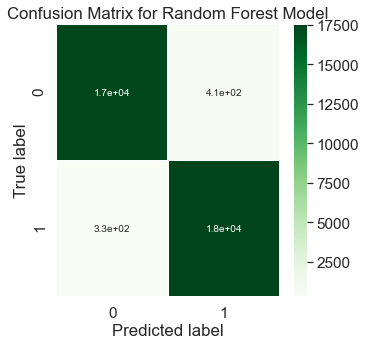

In [22]:
import seaborn
plt.figure(figsize=(5,5))
sns.set(font_scale=1.4)
seaborn.heatmap(CM,annot=True,cmap=plt.cm.Greens,annot_kws={'size':10},linewidths=0.2)
class_names = [0,1]
tick_marks = np.arange(len(class_names))
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [23]:
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

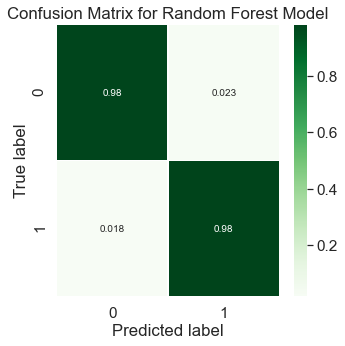

In [24]:
plt.figure(figsize=(5,5))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)


class_names = [0,1]
tick_marks = np.arange(len(class_names))

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [25]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     17776
           1       0.98      0.98      0.98     17849

    accuracy                           0.98     35625
   macro avg       0.98      0.98      0.98     35625
weighted avg       0.98      0.98      0.98     35625



## Logistic Regression 

In [26]:
logisticRegr = LogisticRegression(random_state = 42)
logisticRegr.fit(X_train, y_train)

/Users/guoyuxin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [27]:
preds = logisticRegr.predict_proba(X_test)
tpr, tpr, thresholds = metrics.roc_curve(y_test,preds[:,1])
print (thresholds)

accuracy_ls = []
for thres in thresholds:
    y_pred = np.where(preds[:,1]>thres,1,0)
    # Apply desired utility function to y_preds, for example accuracy.
    accuracy_ls.append(metrics.accuracy_score(y_test, y_pred, normalize=True))

[1.8034755  0.8034755  0.80156806 ... 0.22806442 0.20461966 0.20130573]


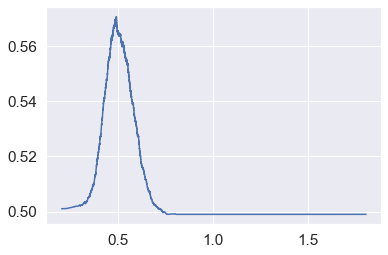

In [28]:
plt.plot(thresholds,accuracy_ls)

In [29]:
cutoff=pd.DataFrame(thresholds,columns=['cut-off'])
cutoff['Accuracy Score']=accuracy_ls

In [52]:
max_cof=cutoff['cut-off'][cutoff['Accuracy Score']==cutoff['Accuracy Score'].max()].values

In [53]:
y_pred = np.where(preds[:,1]>max_cof,1,0)

In [54]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.5707071438977613

In [55]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.54      0.55     17776
           1       0.57      0.61      0.59     17849

    accuracy                           0.57     35625
   macro avg       0.57      0.57      0.57     35625
weighted avg       0.57      0.57      0.57     35625



## XGBoost

In [33]:
def roc_auc_plot(fpr, tpr, roc_auc):
    plt.figure()
    plt.plot(fpr, tpr, label='XGBoost (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()

In [40]:
xgb = XGBClassifier(objective = 'binary:logistic')
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

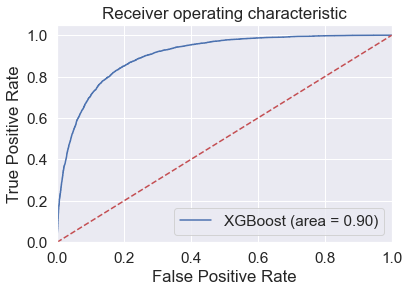

Accuracy: 82.5740%


In [41]:
# Predicting with test data
y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
predictions = [round(value) for value in y_pred]
roc_auc = roc_auc_score(y_test, y_prob)
roc_auc_plot(fpr, tpr, roc_auc)

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.4f%%" % (accuracy * 100.0))

In [42]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.82      0.82     17776
           1       0.82      0.83      0.83     17849

    accuracy                           0.83     35625
   macro avg       0.83      0.83      0.83     35625
weighted avg       0.83      0.83      0.83     35625



## Apply the best model to the holdout

In [48]:
holdout_pred=clf.predict(Holdout)

In [ ]:
holdout_pred.to_csv("Holdout_pred.csv")